In [16]:
import pandas as pd


unseen_data_path = "../data/unseen/client_ceas_unseen_balanced.csv"
df_unseen = pd.read_csv(unseen_data_path)

# Show the first few rows to ensure the data is correct
df_unseen.head()




,sender,receiver,date,subject,body,label,urls
0,CNN Alerts <frakte_1973@emmeffe.net>,email151@gvc.ceas-challenge.cc,"Fri, 08 Aug 2008 10:06:51 -0400",CNN Alerts: My Custom Alert,\n\nCNN Alerts: My Custom Alert\n\n\n\n\n\n\n ...,1,0
1,CNN Alerts <steffi-egnalnek@sorrentolactalis.com>,email775@gvc.ceas-challenge.cc,"Fri, 08 Aug 2008 10:04:01 -0400",CNN Alerts: My Custom Alert,\n\nCNN Alerts: My Custom Alert\n\n\n\n\n\n\n ...,1,0
2,SpamExperts via Twitter <uiaregi@twitter.com>,user2.1@gvc.ceas-challenge.cc,"Fri, 08 Aug 2008 12:28:09 +0000",Direct message from SpamExperts via web,zz Memory lack of (10min) mt_se_xen3: ON\n7.86...,0,1
3,"""Astrology.com Daily Horoscope"" <dailyhoroscop...",gvcormac@gvc.ceas-challenge.cc,"Fri, 08 Aug 2008 06:35:35 -0700",Astrology.com: Daily Horoscope,\n\nAstrology.com Daily Horoscope\n\n\n\n\nHor...,0,1
4,CNN Alerts <lessomed@4wcz.tk>,user4@gvc.ceas-challenge.cc,"Fri, 08 Aug 2008 07:36:51 -0400",CNN Alerts: My Custom Alert,\n\n\nCNN Alerts: My Custom Alert\n\n\n\n\n\n\...,1,0


In [17]:
df_unseen.shape

(1666, 7)

In [18]:
# Check the column names of the unseen test data
print(df_unseen.columns)


Index(['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls'], dtype='object')


In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import re

# Define feature extraction functions for unseen data
def extract_domain(email):
    try:
        return email.split("@")[-1].lower()
    except:
        return "unknown"

def is_public_domain(domain):
    public_domains = {"gmail.com", "yahoo.com", "outlook.com", "hotmail.com", "aol.com", "protonmail.com"}
    return int(domain in public_domains)

def count_suspicious_chars(s):
    return sum(s.count(c) for c in ['-', '_', '~', '%', '='])

def has_digits(s):
    return int(any(char.isdigit() for char in s))

def get_tld(domain):
    parts = domain.split(".")
    return parts[-1] if len(parts) > 1 else "unknown"

def extract_url_features(text):
    url_pattern = r"(https?://[^\s]+)"
    urls = re.findall(url_pattern, str(text))
    url_count = len(urls)
    url_lengths = [len(u) for u in urls]
    avg_length = np.mean(url_lengths) if url_lengths else 0
    max_length = np.max(url_lengths) if url_lengths else 0
    has_ip = int(any(re.search(r"http[s]?://(?:\d{1,3}\.){3}\d{1,3}", u) for u in urls))
    has_special_chars = sum(u.count('?') + u.count('&') + u.count('=') + u.count('@') + u.count('%') for u in urls)
    has_redirect = int(any(u.count("//") > 1 or u.count("http") > 1 for u in urls))

    suspicious_tlds = {"tk", "xyz", "ru", "top", "ml", "ga", "cf", "gq"}
    tlds = []
    for u in urls:
        try:
            parsed = urlparse(u)
            domain = parsed.netloc
            if domain:
                tlds.append(get_tld(domain))
        except:
            continue
    has_suspicious_tld = int(any(tld in suspicious_tlds for tld in tlds))
    return pd.Series([url_count, avg_length, max_length, has_ip, has_special_chars, has_redirect, has_suspicious_tld])

def build_metadata_features(df):
    df = df.copy()
    df["sender_domain"] = df["sender"].apply(extract_domain)
    df["receiver_domain"] = df["receiver"].apply(extract_domain)

    df["sender_domain_length"] = df["sender_domain"].apply(len)
    df["sender_has_digits"] = df["sender_domain"].apply(has_digits)
    df["sender_has_special_chars"] = df["sender_domain"].apply(count_suspicious_chars)
    df["sender_tld"] = df["sender_domain"].apply(get_tld)
    df["sender_is_public_domain"] = df["sender_domain"].apply(is_public_domain)
    df["receiver_is_undisclosed"] = df["receiver"].fillna("").str.contains("undisclosed", case=False).astype(int)
    df["receiver_is_public_domain"] = df["receiver_domain"].apply(is_public_domain)
    df["sender_equals_receiver"] = (df["sender_domain"] == df["receiver_domain"]).astype(int)

    # Date-based features
    df["date"] = pd.to_datetime(df["date"], errors='coerce', utc=True)
    df["email_hour"] = df["date"].dt.hour.fillna(-1).astype(int)
    df["email_weekday"] = df["date"].dt.weekday.fillna(-1).astype(int)
    df["is_weekend"] = df["email_weekday"].isin([5, 6]).astype(int)
    df["is_midnight_hour"] = df["email_hour"].isin(range(0, 6)).astype(int)
    df["has_valid_date"] = df["email_hour"].apply(lambda x: 1 if x != -1 else 0)

    # URL-based features from body
    url_feats = df["body"].apply(extract_url_features)
    url_feats.columns = ["url_count_in_body", "url_avg_length", "url_max_length",
                         "url_has_ip", "url_has_special_chars", "url_has_redirect", "url_suspicious_tld"]
    df = pd.concat([df, url_feats], axis=1)

    # Text statistics
    df["subject_length"] = df["subject"].fillna("").apply(len)
    df["body_length"] = df["body"].fillna("").apply(len)
    df["text_combined_length"] = df["subject_length"] + df["body_length"]
    df["uppercase_ratio"] = df["body"].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / len(str(x)) if len(str(x)) > 0 else 0)
    df["exclamation_count"] = df["body"].fillna("").str.count("!")

    df["url_present"] = df["urls"]
    df["label"] = df["label"]

    # Label encode categorical columns
    le = LabelEncoder()
    df["sender_tld"] = le.fit_transform(df["sender_tld"].astype(str))

    # Select relevant columns
    selected_columns = [
        "sender_domain_length", "sender_has_digits", "sender_has_special_chars",
        "sender_tld", "sender_is_public_domain", "receiver_is_undisclosed",
        "receiver_is_public_domain", "sender_equals_receiver", "email_hour",
        "email_weekday", "is_weekend", "is_midnight_hour", "has_valid_date",  # ✅ NEW
        "url_present", "url_count_in_body", "url_avg_length", "url_max_length",
        "url_has_ip", "url_has_special_chars", "url_has_redirect", "url_suspicious_tld",
        "subject_length", "body_length", "text_combined_length", "uppercase_ratio",
        "exclamation_count", "label"
    ]
    return df[selected_columns]

# Apply to unseen test data
df_unseen = pd.read_csv('../data/unseen/client_ceas_unseen_balanced.csv')  # Load the unseen test data

# Apply the feature engineering steps
df_unseen_features = build_metadata_features(df_unseen)

# Save the processed features for XGBoost
xgb_save_path = "../data/unseen/client_ceas_unseen_xgb_features.csv"
df_unseen_features.to_csv(xgb_save_path, index=False)
print(f"✅ XGBoost features saved to: {xgb_save_path}")


✅ XGBoost features saved to: ../data/unseen/client_ceas_unseen_xgb_features.csv


In [24]:
df_unseen_features.head()

,sender_domain_length,sender_has_digits,sender_has_special_chars,sender_tld,sender_is_public_domain,receiver_is_undisclosed,receiver_is_public_domain,sender_equals_receiver,email_hour,email_weekday,...,url_has_ip,url_has_special_chars,url_has_redirect,url_suspicious_tld,subject_length,body_length,text_combined_length,uppercase_ratio,exclamation_count,label
0,12,0,0,47,0,0,0,0,14,4,...,0.0,0.0,0.0,0.0,27,587,614,0.095400,0,1
1,21,0,0,18,0,0,0,0,14,4,...,0.0,0.0,0.0,0.0,27,548,575,0.098540,0,1
2,12,0,0,18,0,0,0,0,12,4,...,0.0,0.0,0.0,0.0,39,361,400,0.058172,0,0
3,14,0,0,18,0,0,0,0,13,4,...,0.0,0.0,0.0,0.0,30,5203,5233,0.040169,9,0
4,8,1,0,62,0,0,0,0,11,4,...,0.0,0.0,0.0,0.0,27,562,589,0.096085,0,1


Missing Values:
 sender       0
receiver    14
date         0
subject      0
body         0
label        0
urls         0
dtype: int64

Number of Duplicates: 0

Data Distribution (Phishing vs Legitimate):
 label
1    833
0    833
Name: count, dtype: int64

Summary Statistics:
             label        urls
count  1666.00000  1666.00000
mean      0.50000     0.50000
std       0.50015     0.50015
min       0.00000     0.00000
25%       0.00000     0.00000
50%       0.50000     0.50000
75%       1.00000     1.00000
max       1.00000     1.00000


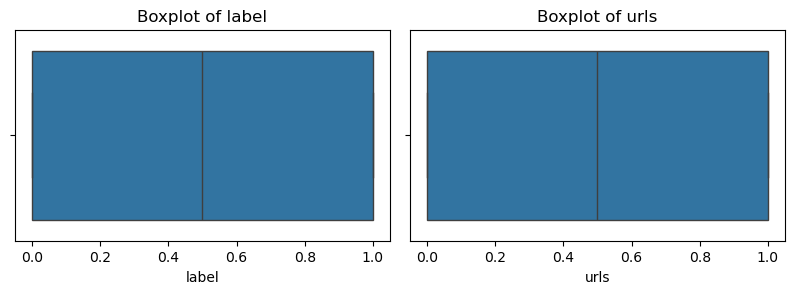

In [21]:
# 1. Check for missing values
missing_values = df_unseen.isnull().sum()

# 2. Check for duplicates
duplicates = df_unseen.duplicated().sum()

# 3. Check data distribution (Phishing vs Legitimate)
label_distribution = df_unseen['label'].value_counts()

# 4. Summary statistics to check for outliers
summary_stats = df_unseen.describe()

# Show the results
print("Missing Values:\n", missing_values)
print("\nNumber of Duplicates:", duplicates)
print("\nData Distribution (Phishing vs Legitimate):\n", label_distribution)
print("\nSummary Statistics:\n", summary_stats)

# If needed, visualize outliers in numerical features
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizing outliers using boxplots for numeric columns
numeric_columns = df_unseen.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 3, i)  # Adjust subplot grid as per number of columns
    sns.boxplot(data=df_unseen, x=col)
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


In [20]:
df_unseen_features.shape


(1666, 27)

In [26]:
# First, make sure to calculate 'url_length_ratio' and 'url_density'
df_unseen_features["url_length_ratio"] = df_unseen_features["url_avg_length"] / (df_unseen_features["url_max_length"] + 1e-5)
df_unseen_features["url_density"] = df_unseen_features["url_count_in_body"] / (df_unseen_features["body_length"] + 1e-5)

# Now, drop any additional features not in the list of required features
required_features = [
    'sender_domain_length', 'sender_has_digits', 'sender_has_special_chars', 'sender_tld', 
    'sender_is_public_domain', 'receiver_is_undisclosed', 'receiver_is_public_domain', 
    'sender_equals_receiver', 'email_hour', 'is_weekend', 'url_present', 'url_has_ip', 
    'url_has_special_chars', 'url_has_redirect', 'url_suspicious_tld', 'subject_length', 
    'body_length', 'text_combined_length', 'uppercase_ratio', 'exclamation_count', 'label', 
    'url_length_ratio', 'url_density'
]

# Select only the required features
df_unseen_cleaned = df_unseen_features[required_features]

# Save the cleaned dataset
unseen_save_path = "../data/unseen/client_ceas_unseen_cleaned.csv"
df_unseen_cleaned.to_csv(unseen_save_path, index=False)

print(f"✅ Cleaned dataset with only the required features saved to {unseen_save_path}")


✅ Cleaned dataset with only the required features saved to ../data/unseen/client_ceas_unseen_cleaned.csv


In [27]:
df_unseen_cleaned.shape


(1666, 23)

In [28]:
print(", ".join(df_unseen_cleaned.columns))


sender_domain_length, sender_has_digits, sender_has_special_chars, sender_tld, sender_is_public_domain, receiver_is_undisclosed, receiver_is_public_domain, sender_equals_receiver, email_hour, is_weekend, url_present, url_has_ip, url_has_special_chars, url_has_redirect, url_suspicious_tld, subject_length, body_length, text_combined_length, uppercase_ratio, exclamation_count, label, url_length_ratio, url_density
